In [1]:
!ls ../data

test                   train                  unet_brainMRI_seg.hdf5


In [2]:
!ls ../data/test

MildDemented     ModerateDemented NonDemented      VeryMildDemented


In [24]:
! pip install opencv-python -q
! pip install scikit-image -q

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import random
from skimage import exposure
from skimage.util import random_noise
from skimage import transform

### 1.0 Data Import

In [5]:
testdir = './../data/test'
traindir = './../data/train'
categories = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

mildDem678.jpg
(208, 176)


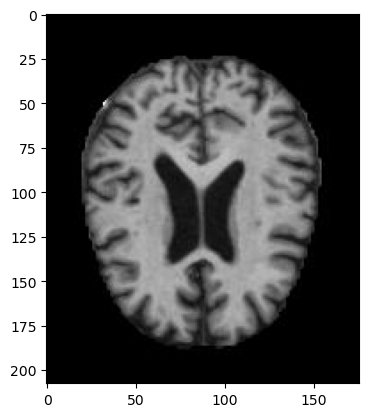

In [6]:
for category in categories:
    path = os.path.join(traindir, category) # path to dementia directory
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        print(img)
        print(img_array.shape)
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break
    break

In [7]:
training_data = []

def create_training_data():
    for category in categories:
        path = os.path.join(traindir, category) # path to dementia directory
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                training_data.append([img_array, class_num])

            except Exception as e:
                pass
        
create_training_data()

In [8]:
test_data = []

def create_test_data():
    for category in categories:
        path = os.path.join(testdir, category) # path to dementia directory
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                test_data.append([img_array, class_num])

            except Exception as e:
                pass
        
create_test_data()

In [9]:
print(len(training_data))
print(len(test_data))

5121
1279


In [10]:
df_train = pd.DataFrame(training_data)
df_test = pd.DataFrame(test_data)

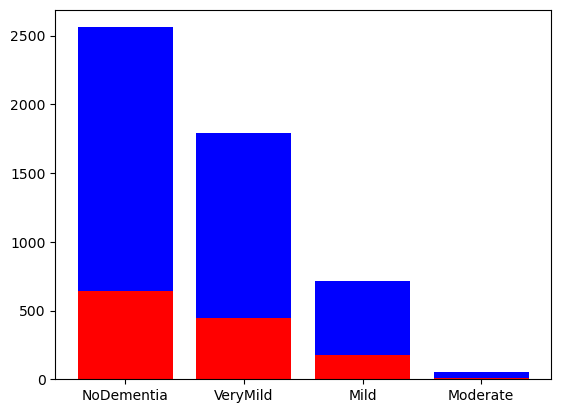

Test Data Counts: 
 2    2560
3    1792
0     717
1      52
Name: 1, dtype: int64 

 Train Data Counts: 
 2    640
3    448
0    179
1     12
Name: 1, dtype: int64


In [11]:
labels=['NoDementia', 'VeryMild', 'Mild', 'Moderate']
y1 = df_train[1].value_counts()
y2 = df_test[1].value_counts()

plt.bar(x=labels, height=y1, color='b')
plt.bar(x=labels, height=y2, color='r')
plt.show()
print('Test Data Counts: \n',y1,'\n\n','Train Data Counts: \n',y2)

### 1.1 Data Wrangling (Prep for Binary Classification + Multi-class Classification)

Since the data is heavily imbalanced, there is reason to include moderate, or late stage alzhiemer's (relative to our other categories) as an independent category. Instead, two different data formats will be tried: (a) binary classification of non-demented and demented (b) three way classificaion of non-demented, early-stage-demented, developed-demented. For the later, all 'moderate' will be reclassified as mild. 

All datasets will be shuffled in order to support model prediction.

In [12]:
### binary classification data

df_bin_train = df_train.copy()

In [13]:
df_bin_train[1]= df_bin_train[1].replace({3:1, 0:1})

In [14]:
df_bin_train[1] = df_bin_train[1].replace({2:0})

In [15]:
df_bin_test = df_test.copy()
df_bin_test[1] = df_bin_test[1].replace({3:1, 0:1})
df_bin_test[1] = df_bin_test[1].replace({2:0})

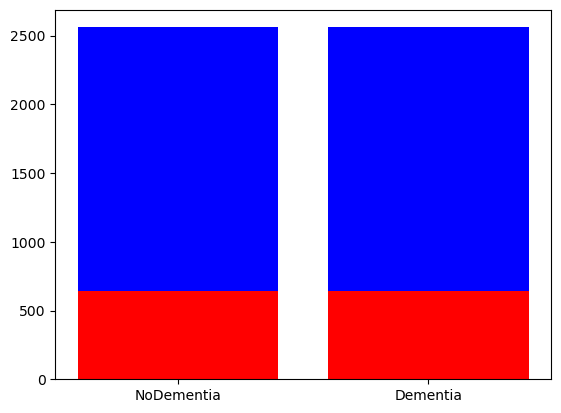

Test Data Counts: 
 1    2561
0    2560
Name: 1, dtype: int64 

 Train Data Counts: 
 0    640
1    639
Name: 1, dtype: int64


In [16]:
labels=['NoDementia', 'Dementia']
y1 = df_bin_train[1].value_counts()
y2 = df_bin_test[1].value_counts()

plt.bar(x=labels, height=y1, color='b')
plt.bar(x=labels, height=y2, color='r')
plt.show()
print('Test Data Counts: \n',y1,'\n\n','Train Data Counts: \n',y2)

In [17]:
### Non, Early, Developed

df_tri_train = df_train.copy()
df_tri_train[1]= df_tri_train[1].replace({2:4})
df_tri_train[1]= df_tri_train[1].replace({0:2, 1:2})
df_tri_train[1]= df_tri_train[1].replace({3:1, 4:0})

df_tri_test = df_test.copy()
df_tri_test[1]= df_tri_test[1].replace({2:4})
df_tri_test[1]= df_tri_test[1].replace({0:2, 1:2})
df_tri_test[1]= df_tri_test[1].replace({3:1, 4:0})

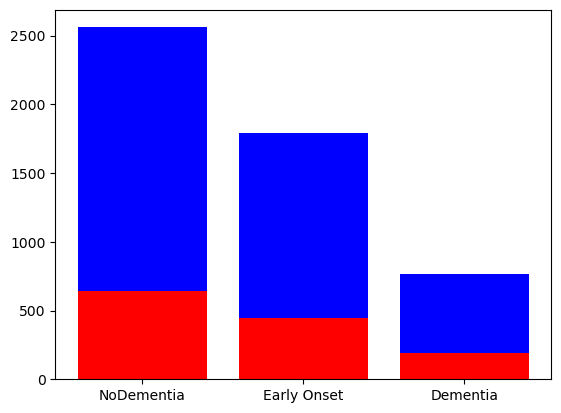

Test Data Counts: 
 0    2560
1    1792
2     769
Name: 1, dtype: int64 

 Train Data Counts: 
 0    640
1    448
2    191
Name: 1, dtype: int64


In [18]:
labels=['NoDementia', 'Early Onset', 'Dementia']
y1 = df_tri_train[1].value_counts()
y2 = df_tri_test[1].value_counts()

plt.bar(x=labels, height=y1, color='b')
plt.bar(x=labels, height=y2, color='r')
plt.show()
print('Test Data Counts: \n',y1,'\n\n','Train Data Counts: \n',y2)

#### Shuffling data

In [19]:
import random

df_bin_train = df_bin_train.sample(frac=1, random_state=1).reset_index()
df_bin_train.drop(columns=df_bin_train.columns[0], 
        axis=1, 
        inplace=True)

In [20]:
df_bin_train.head()


,0,1
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [21]:
df_bin_test = df_bin_test.sample(frac=1, random_state=1).reset_index()
df_bin_test.drop(columns=df_bin_test.columns[0], 
        axis=1, 
        inplace=True)

df_tri_train = df_tri_train.sample(frac=1, random_state=1).reset_index()
df_tri_train.drop(columns=df_tri_train.columns[0], 
        axis=1, 
        inplace=True)

df_tri_test = df_tri_test.sample(frac=1, random_state=1).reset_index()
df_tri_test.drop(columns=df_tri_test.columns[0], 
        axis=1, 
        inplace=True)

### 1.2 Data Prep (Data Augmentation)

Making data to improve the model

In [ ]:
def img_augment(jpg):
    for category in categories:
    path = os.path.join(traindir, category) # path to dementia directory
    for img in os.listdir(path):
    
    